# 1D conventional and optimized acoustic wave equation solver

This is a comparison of conventional and optimized finite difference stencils for solving the acoustic wave equation in 1D with zero Dirichlet boundary conditions. 

Coefficients were optimized using a modified version of the method detailed by Tam and Webb (1992):

Tam, C.K.W. & Webb, J.C., 1993. Dispersion-relation-preserving finite difference schemes for computational acoustics. Journal of Computational Physics, 107(2), pp.262–281.

Solutions for both conventional (4th and 6th order) and optimized (4th order) schemes will be compared to the analytical solution.

## Dispersion characteristics

We will begin by plotting the dispersion curves for the various solutions to demonstrate the improved wavenumber preservation of optimized schemes:

/home/ed/.local/lib/python3.6/site-packages/ipykernel/__main__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
/home/ed/.local/lib/python3.6/site-packages/ipykernel/__main__.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/home/ed/.local/lib/python3.6/site-packages/ipykernel/__main__.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


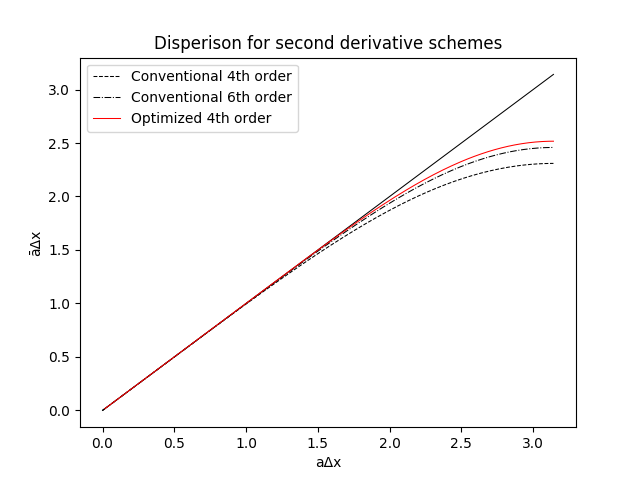

/home/ed/.local/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in sqrt


In [10]:
%matplotlib notebook
from numpy import exp, sum, linspace, pi, array, zeros, sqrt
import matplotlib.pyplot as plt

# Function to evaluate (āΔx)**2 at a given value of aΔx, for a specified set of coefficients 
def a_bar_calc(k, a):
    return -1.*sum([a[i]*exp(float(i-3)*1j*k) for i in range(7)])

# Specify coefficients for conventional and optimized schemes
con4_coeffs = array([0, -1./12.,  4./3., -5./2., 4./3., -1./12., 0])
con6_coeffs = array([1./90., -3./20.,  3./2., -49./18., 3./2., -3./20., 1./90.])
opt4_coeffs = array([0.01564992, -0.17723283,  1.56808208, -2.81299833, 1.56808208, -0.17723283, 0.01564992])

# Create axis for aΔx, and arrays for (āΔx)**2 values for each stencil
adx_vals = linspace(0, pi, 200) 
con4_square_vals = zeros(200)
con6_square_vals = zeros(200)
opt4_square_vals = zeros(200)

# Fill in values
for i in range(200):
    con4_square_vals[i] = a_bar_calc(adx_vals[i], con4_coeffs)
    con6_square_vals[i] = a_bar_calc(adx_vals[i], con6_coeffs)
    opt4_square_vals[i] = a_bar_calc(adx_vals[i], opt4_coeffs)

fig = plt.figure()
plt.plot(adx_vals, adx_vals, 'k-', linewidth=0.75)
plt.plot(adx_vals, sqrt(con4_square_vals), 'k--', linewidth=0.75, label='Conventional 4th order')
plt.plot(adx_vals, sqrt(con6_square_vals), 'k-.', linewidth=0.75, label='Conventional 6th order')
plt.plot(adx_vals, sqrt(opt4_square_vals), 'r-', linewidth=0.75, label='Optimized 4th order')
plt.title("Disperison for second derivative schemes")
plt.legend(loc='best')
plt.xlabel("aΔx")
plt.ylabel("āΔx")
plt.show()

As we can see, the optimized 4th order scheme provides adequate approximation of spatial second derivatives for waves with wavelengths greater than ~3.9Δx: a considerable improvement over the ~5.2Δx for the conventional 4th order scheme, and slightly better performance than conventional 6th order stencils.

## Analytic solution

To quantify the accuracy of the finite difference schemes, it is necessary to analytically solve the wave equation for the given conditions. This solution is implemented and plotted below:

<IPython.core.display.Javascript object>


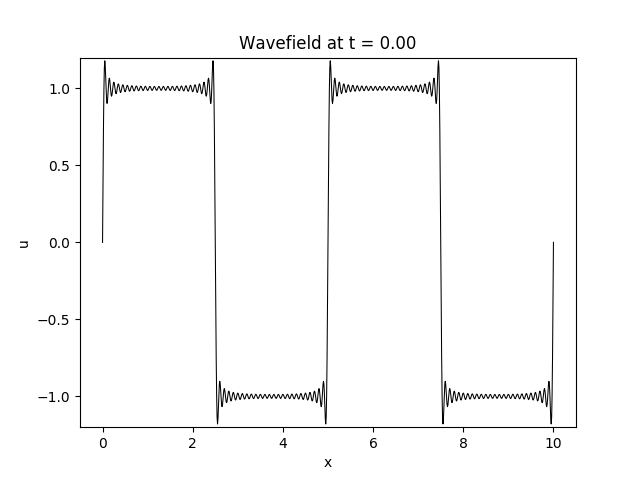

<IPython.core.display.Javascript object>


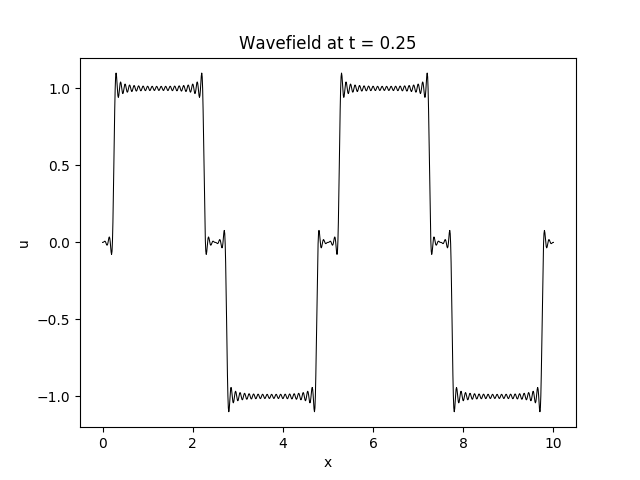

<IPython.core.display.Javascript object>


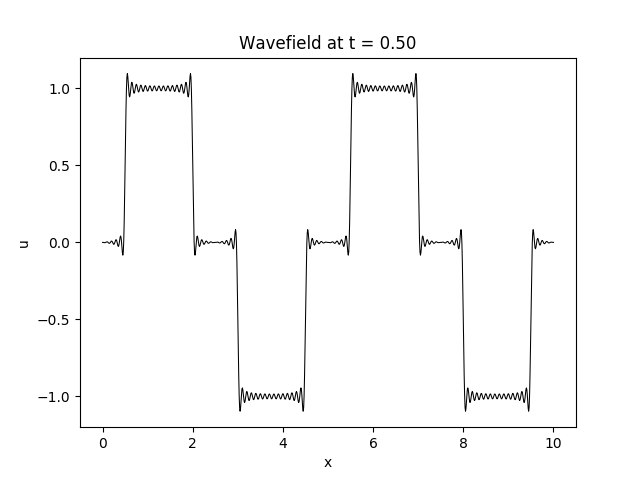

<IPython.core.display.Javascript object>


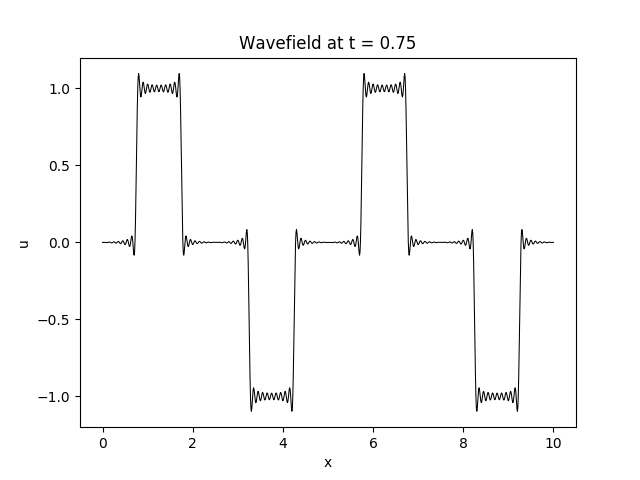

<IPython.core.display.Javascript object>


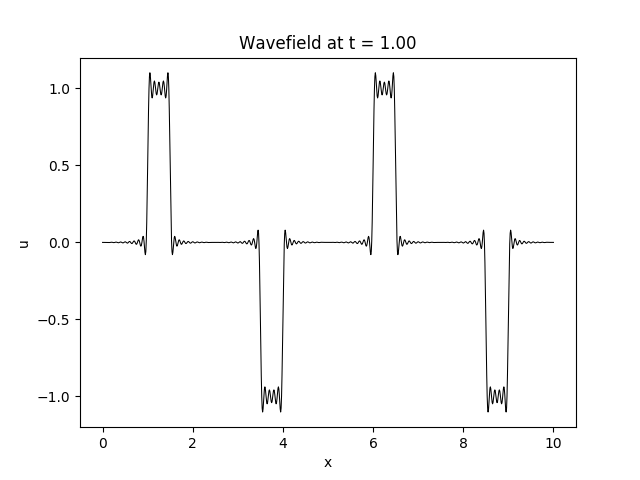

<IPython.core.display.Javascript object>


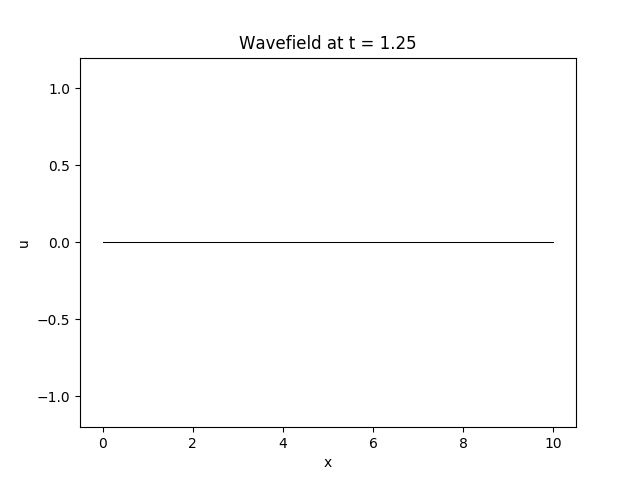

<IPython.core.display.Javascript object>


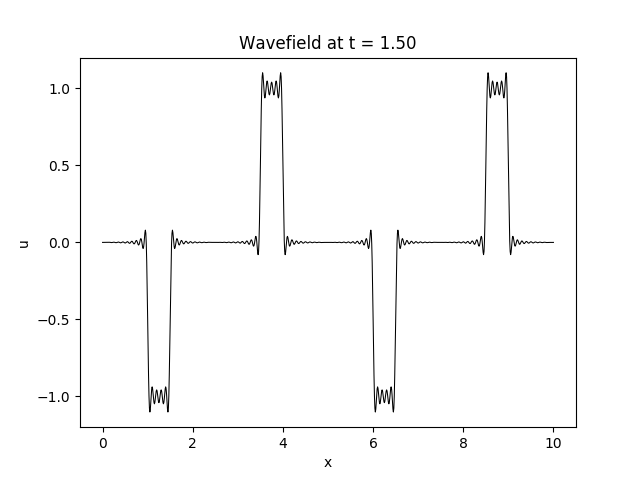

<IPython.core.display.Javascript object>


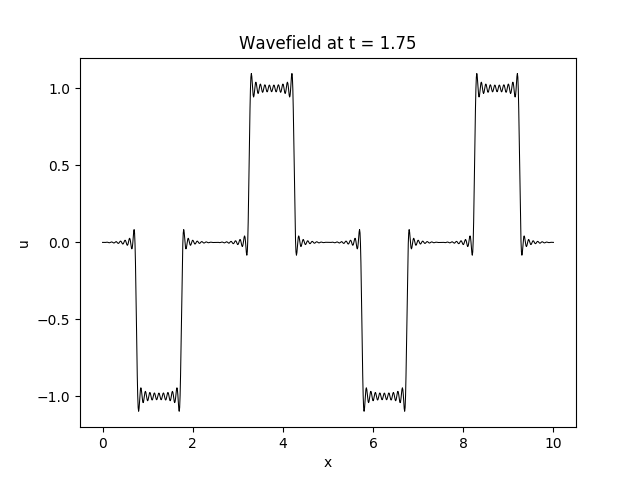

<IPython.core.display.Javascript object>


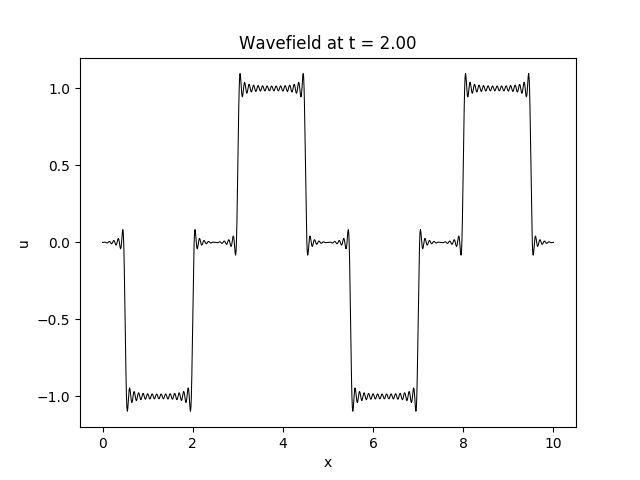

<IPython.core.display.Javascript object>


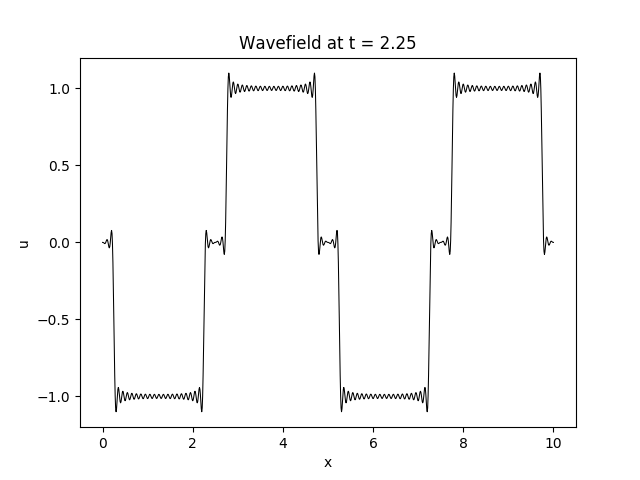

<IPython.core.display.Javascript object>


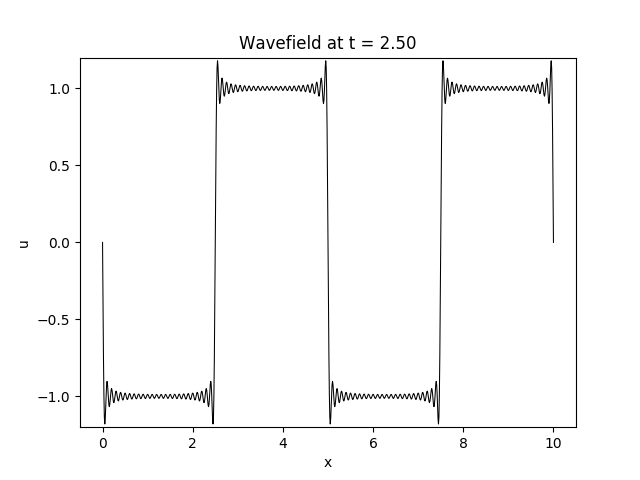

<IPython.core.display.Javascript object>


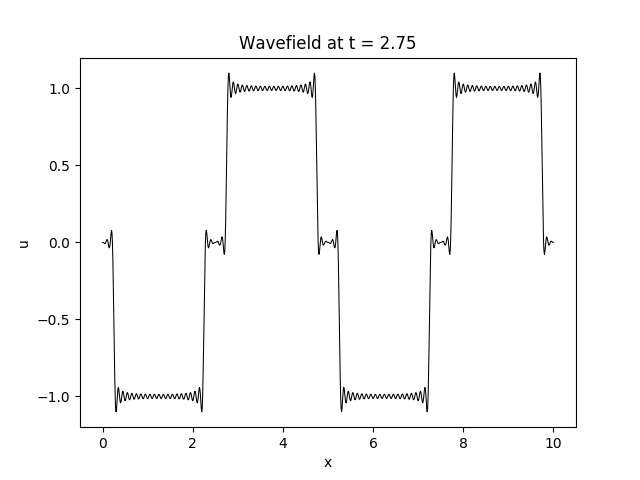

<IPython.core.display.Javascript object>


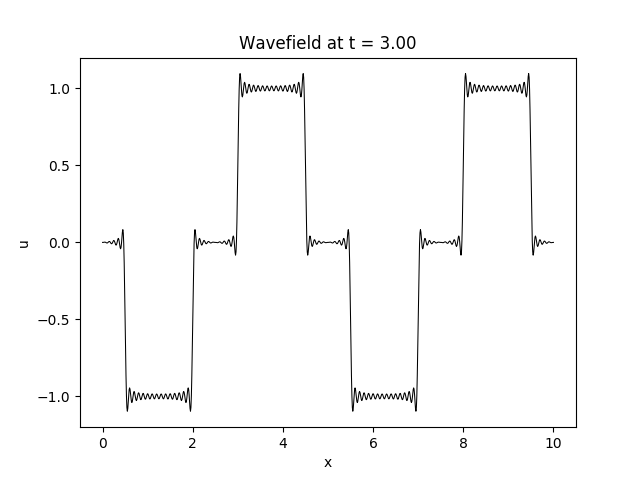

<IPython.core.display.Javascript object>


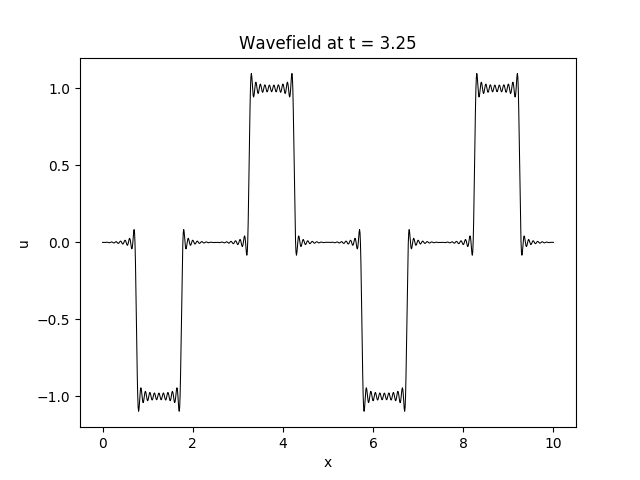

<IPython.core.display.Javascript object>


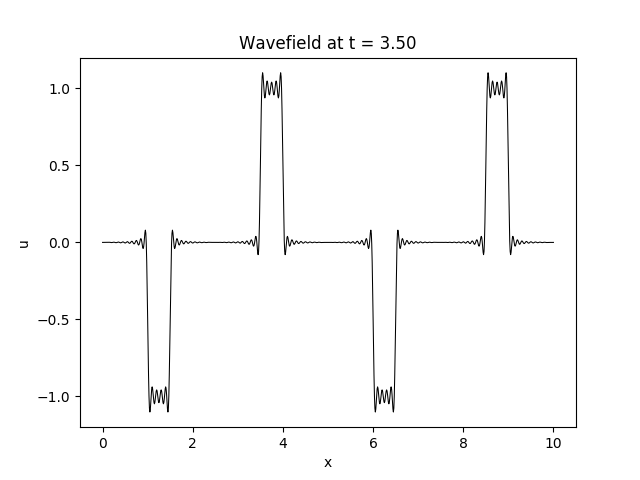

<IPython.core.display.Javascript object>


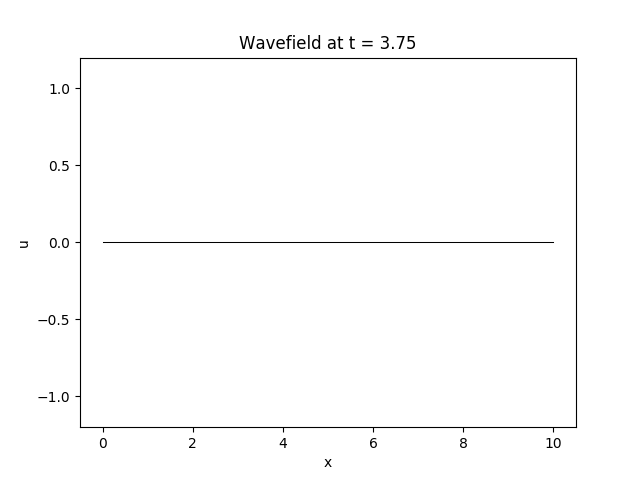

<IPython.core.display.Javascript object>


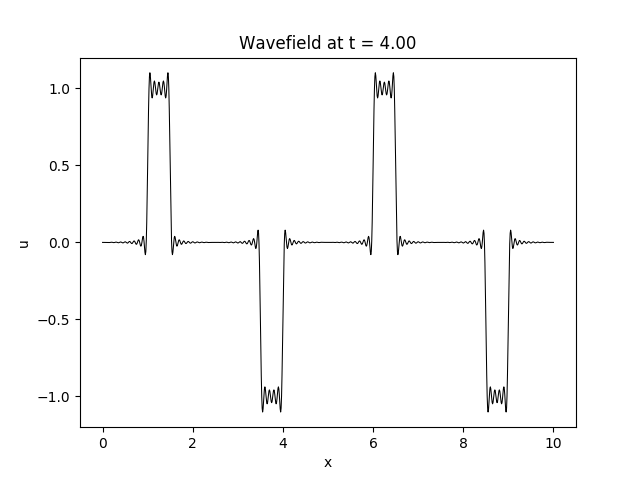

<IPython.core.display.Javascript object>


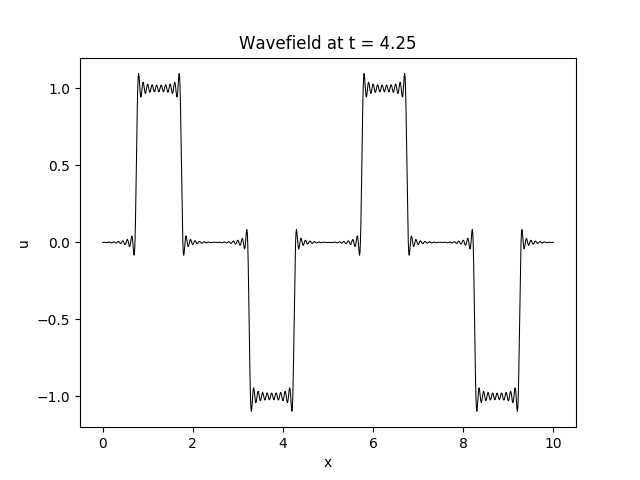

<IPython.core.display.Javascript object>


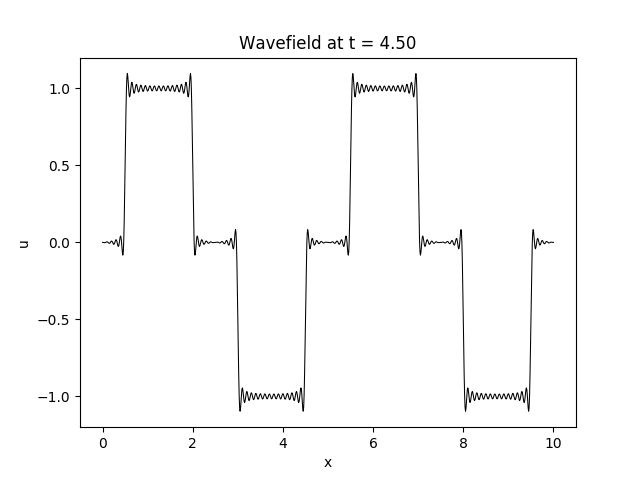

<IPython.core.display.Javascript object>


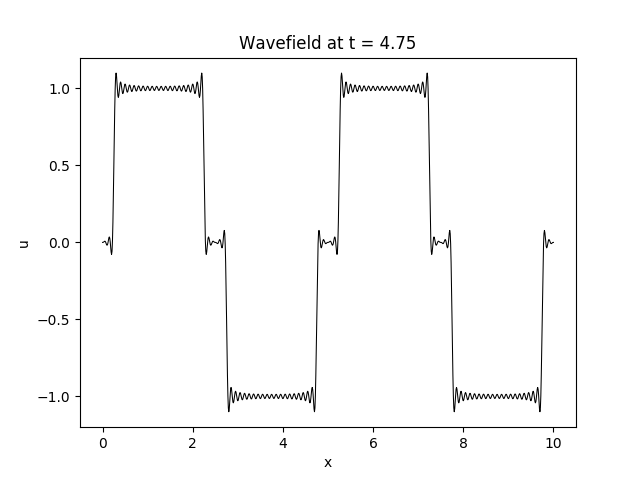

<IPython.core.display.Javascript object>


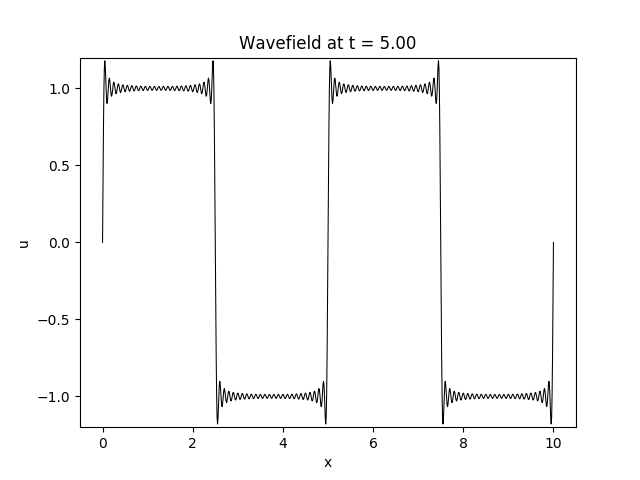

In [22]:
# Import modules for analytic and numerical solutions
import matplotlib.pyplot as plt
from numpy import sin, cos, pi, linspace, array, zeros, trapz, abs, shape
from scipy.integrate import quad
from devito import TimeFunction, Grid, SpaceDimension, Operator, Constant, Eq
from sympy import solve, init_printing, latex
init_printing(use_latex=True)

# Set global constants
L = 10. # Define length of domain as a global variable
k = 100 # Number of terms in the Fourier sine series
l = 1001 # Define number of points in domain
x_vals = linspace(0, L, l) # x axis for calling u(x, t) at given t

# Functions to evaluate u(x, t)
def square_init(x): # Square function to base Fourier series off of
    if x >= 0 and x < L/4.:
        return 1.
    elif x >= L/4. and x < L/2.:
        return -1.
    else:
        return 0.

def D_n_inner(x, n): # Inner part of D_n to allow for scipy.integrate.quad to be used
    return square_init(x)*sin(n*pi*x/L)
    
def D_n_calc(n): # Define function to calculate d_n for a given n
    if n % 2 == 0:
        return (4./L)*quad(D_n_inner, 0, L/2., args=(n))[0]
    else:
        return 0.

def u(x, t): # Analytic solution calculator
    u_temp = 0.
    
    for n in range(1, 2*k+1):
        u_temp += D_n_calc(n)*sin(n*pi*x/L)*cos(n*pi*t/L)
        
    return u_temp


for i in range(21):
    fig = plt.figure()
    plt.plot(x_vals, u(x_vals, i*L/40.), 'k', linewidth=0.75)
    plt.title("Wavefield at t = %.2f" % (i*L/40.))
    plt.ylim(-1.2, 1.2)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.show()

## Conventional finite difference solution

We will now solve the same wave equation problem via a 4th order conventional finite difference scheme using Devito:

Operator `Kernel` run in 0.00 s
/home/ed/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


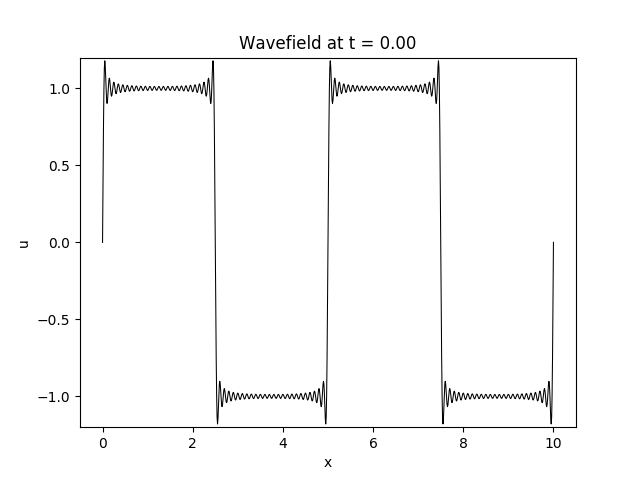

<IPython.core.display.Javascript object>


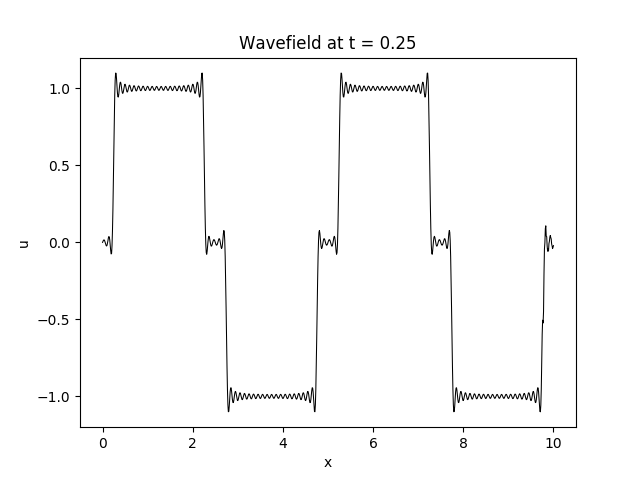

<IPython.core.display.Javascript object>


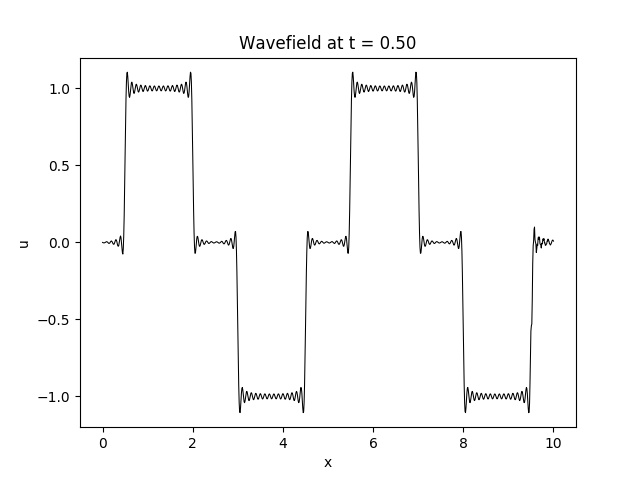

<IPython.core.display.Javascript object>


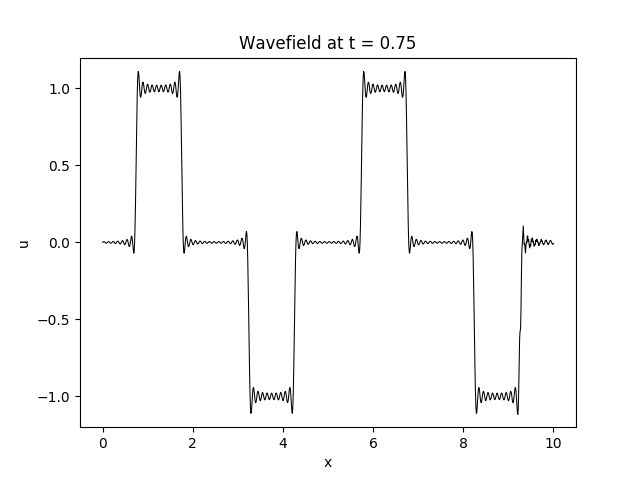

<IPython.core.display.Javascript object>


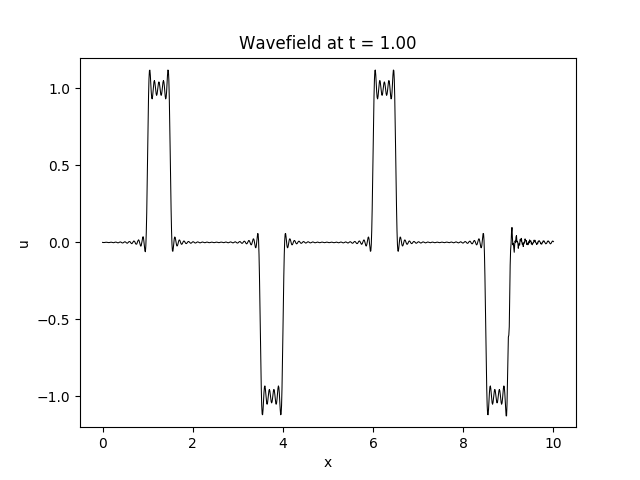

<IPython.core.display.Javascript object>


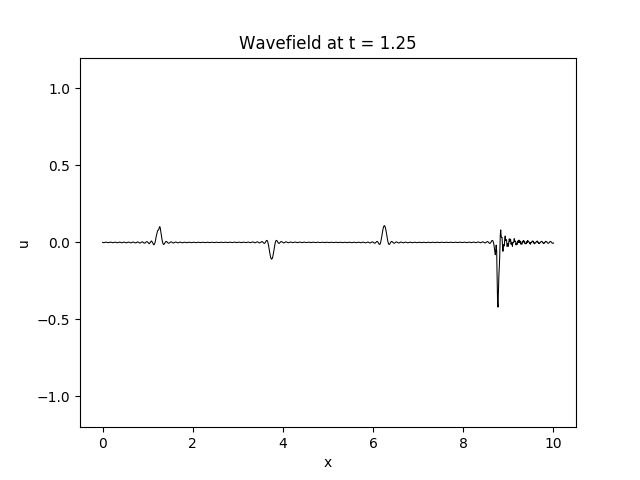

<IPython.core.display.Javascript object>


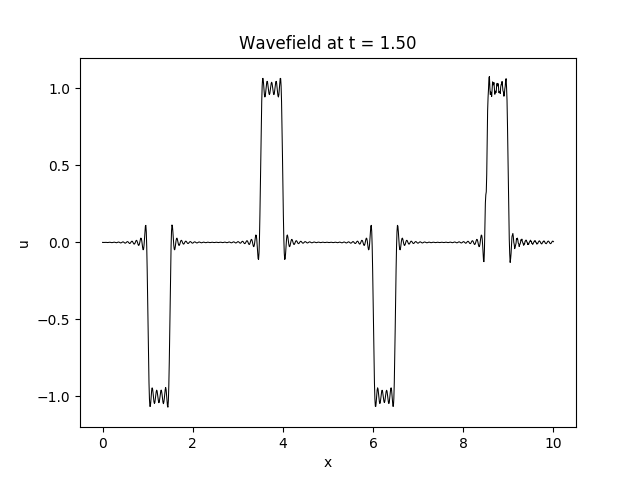

<IPython.core.display.Javascript object>


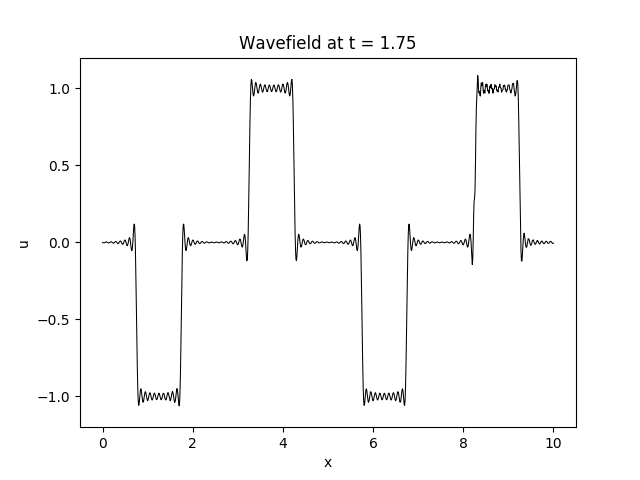

<IPython.core.display.Javascript object>


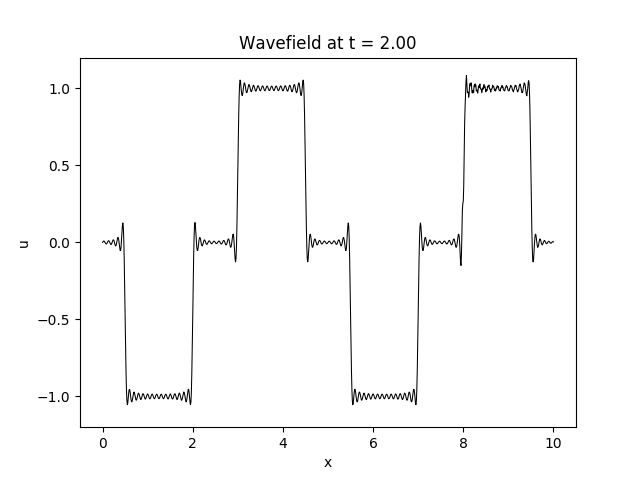

<IPython.core.display.Javascript object>


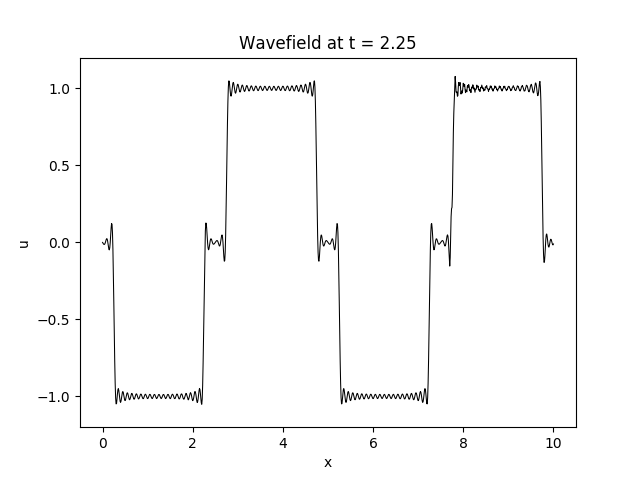

<IPython.core.display.Javascript object>


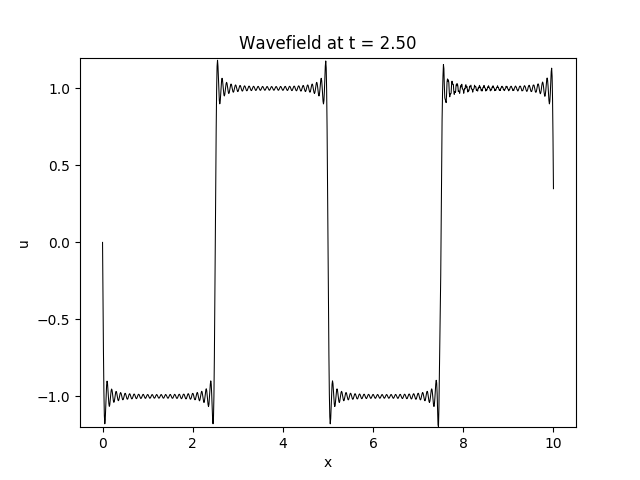

<IPython.core.display.Javascript object>


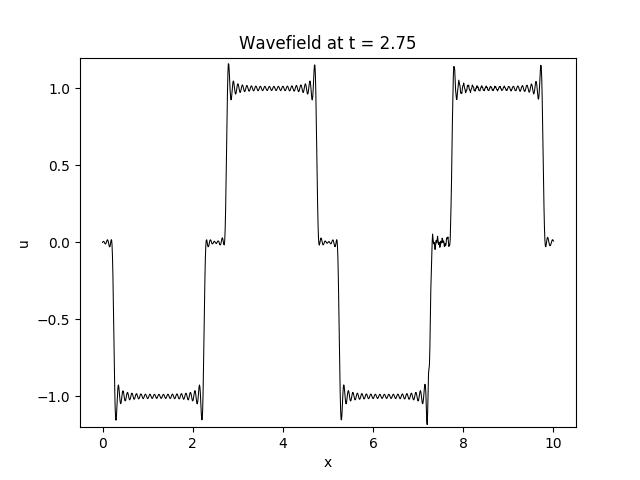

<IPython.core.display.Javascript object>


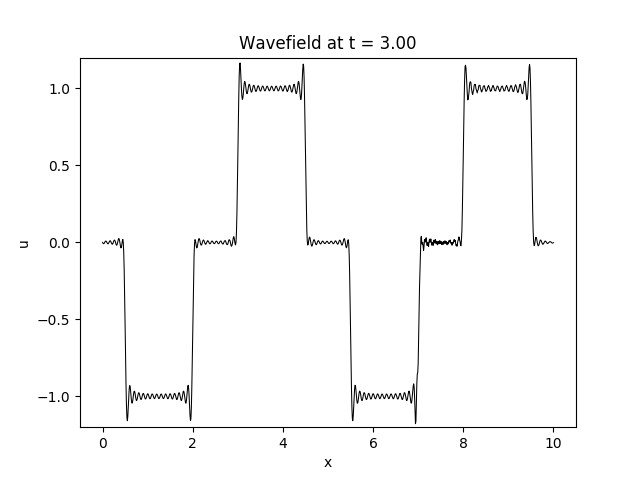

<IPython.core.display.Javascript object>


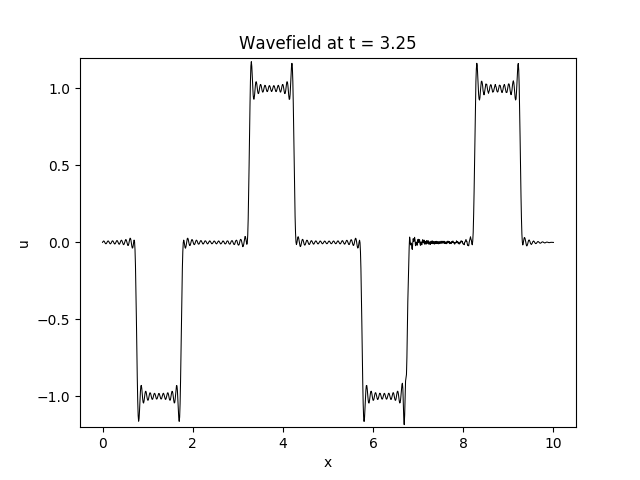

<IPython.core.display.Javascript object>


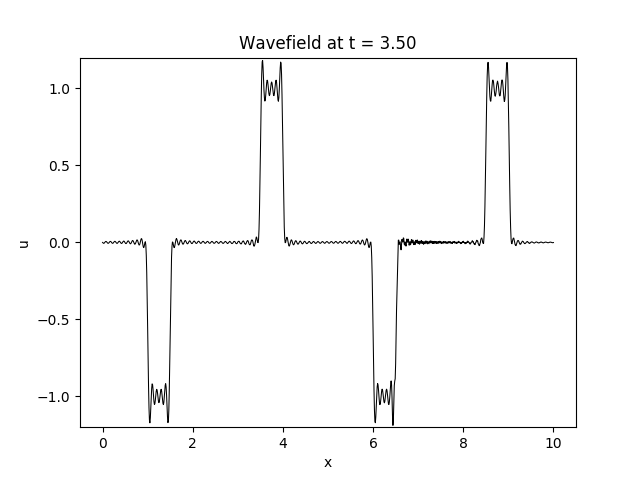

<IPython.core.display.Javascript object>


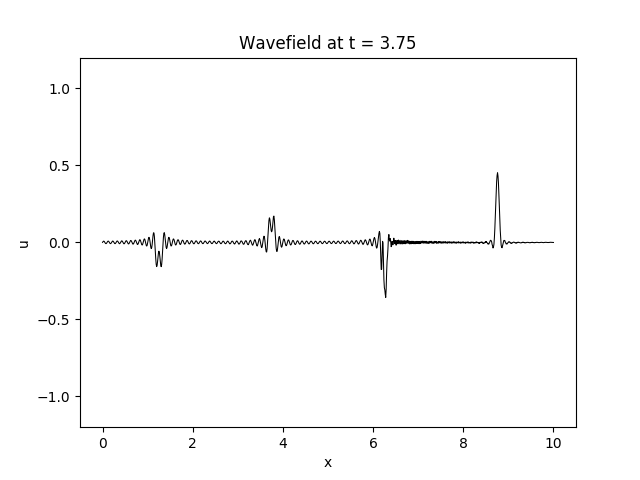

<IPython.core.display.Javascript object>


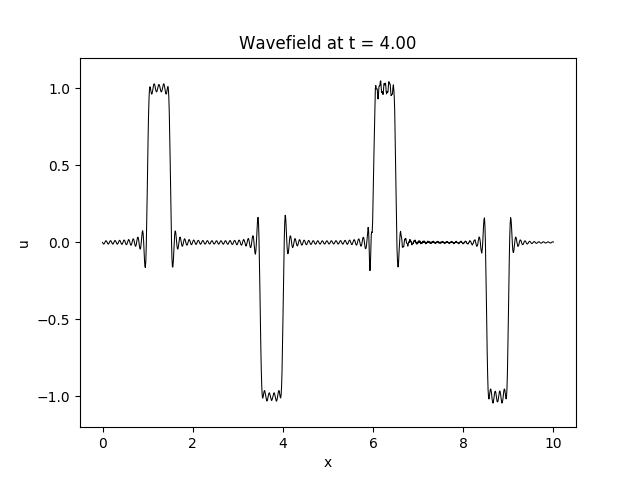

<IPython.core.display.Javascript object>


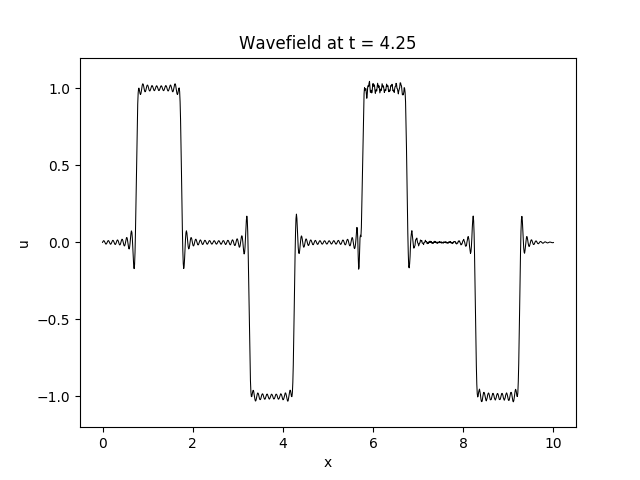

<IPython.core.display.Javascript object>


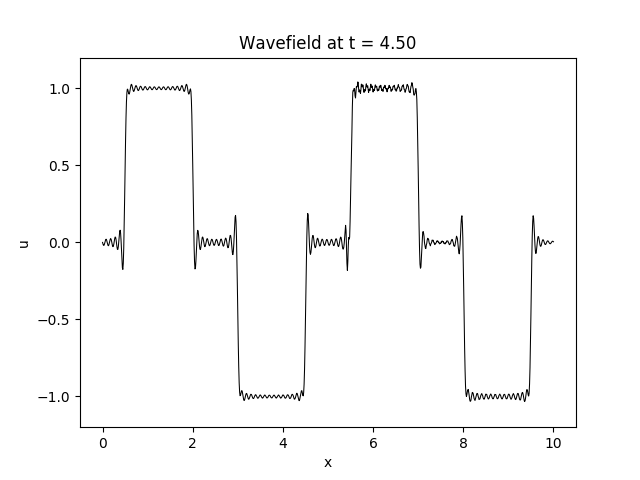

<IPython.core.display.Javascript object>


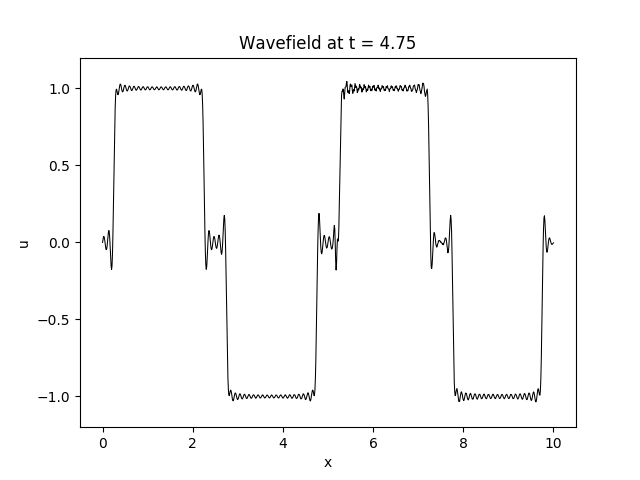

<IPython.core.display.Javascript object>


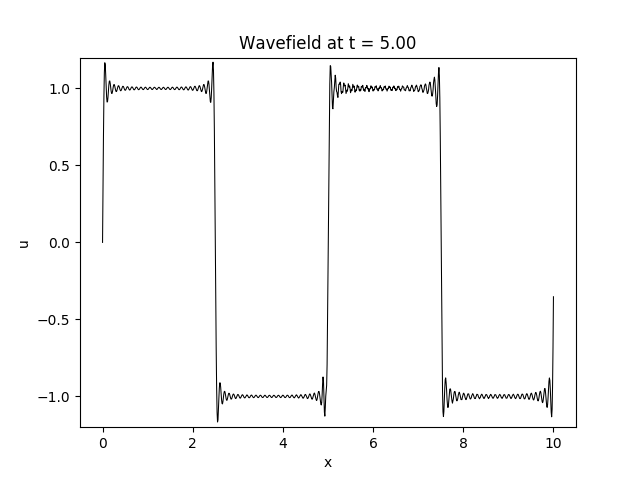

In [29]:
# Set up conventional FD parameters
so_dev = 4 # 4th order accurate in space
to_dev = 2 # 2nd order accurate in time

extent = (L,) # Grid is L long with l grid points
shape = (l,)
# dt is defined using Courant condition (c = 1)
dt = 0.6*(L/(shape[0]-1)) # Timestep is half critical dt (0.0025)
t_end = L # Standing wave will cycle twice in time L
ns = int(t_end/dt) # Number of timesteps = total time/timestep size

# Define x as spatial dimention for Sympy
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))

grid = Grid(extent=extent, shape=shape, dimensions=(x,))
time = grid.time_dim

# Set up function and stencil
u_dev = TimeFunction(name="u_dev", grid=grid, space_order=so_dev, time_order=to_dev, save=ns+1)
stencil_dev = Eq(u_dev.forward, solve(u_dev.dx2 - u_dev.dt2, u_dev.forward)[0])

bc = [Eq(u_dev[time+1,0], 0.0)] # Specify Dirichlet boundary conditions
bc += [Eq(u_dev[time+1,-1], 0.0)]

# Functions for initalizing standing square wave
def b_n_inner(x, n): # Inner part of b_n to allow for scipy.integrate.quad to be used
    return square_init(x)*sin(2.*n*pi*x/L)

def b_n_calc(n):
    return (4./L)*quad(b_n_inner, 0, L/2., args=(n))[0]
    
def u_init(x):
    u_temp = 0.
    for n in range(1, k+1):
        u_temp += b_n_calc(n)*sin(2.*n*pi*x/L) 
    return u_temp

# Initialize wavefield
u_dev.data[:] = u_init(linspace(0, L, u_dev.data.shape[1]))
# Create operator
op_dev = Operator([stencil_dev] + bc)
# Apply operator
op_dev.apply(time_M=ns-1, dt=dt)

for i in range(21):
    fig = plt.figure()
    plt.plot(x_vals, u_dev.data[int(i*(u_dev.data.shape[0]-2)/40.)], 'k', linewidth=0.75)
    plt.title("Wavefield at t = %.2f" % (i*L/40.))
    plt.ylim(-1.2, 1.2)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.show()

And now via a 4th order optimized finite difference scheme:

Operator `Kernel` run in 0.00 s
/home/ed/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


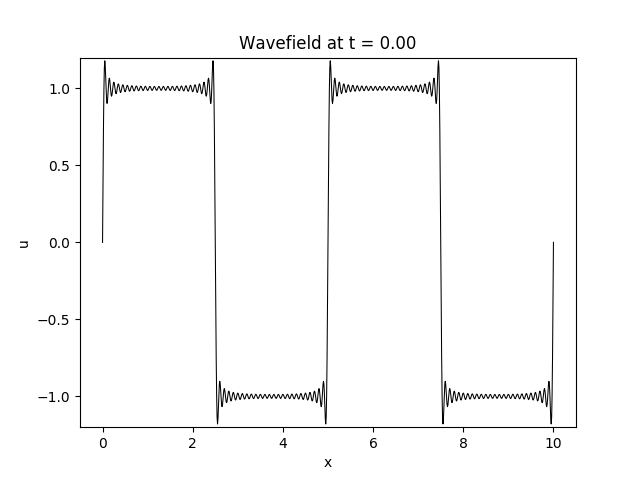

<IPython.core.display.Javascript object>


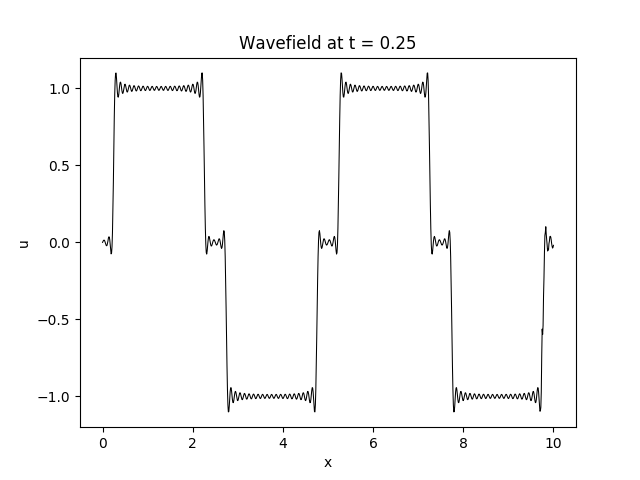

<IPython.core.display.Javascript object>


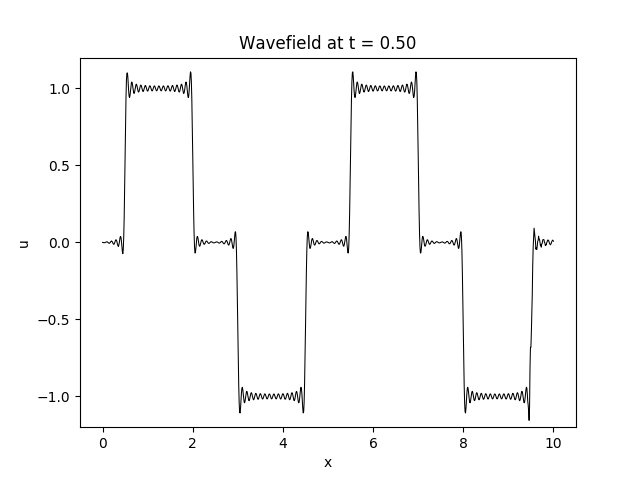

<IPython.core.display.Javascript object>


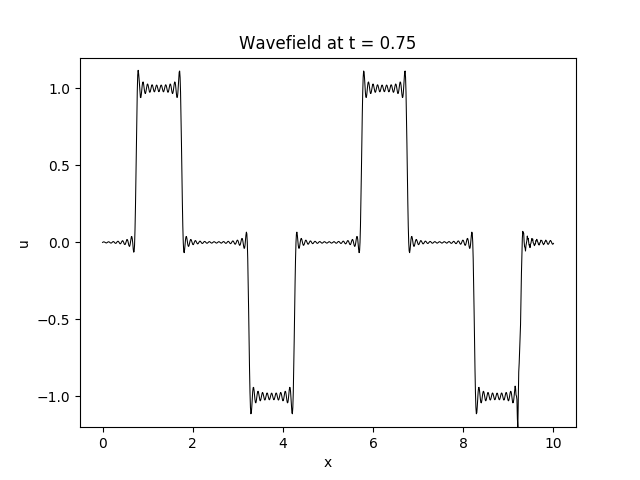

<IPython.core.display.Javascript object>


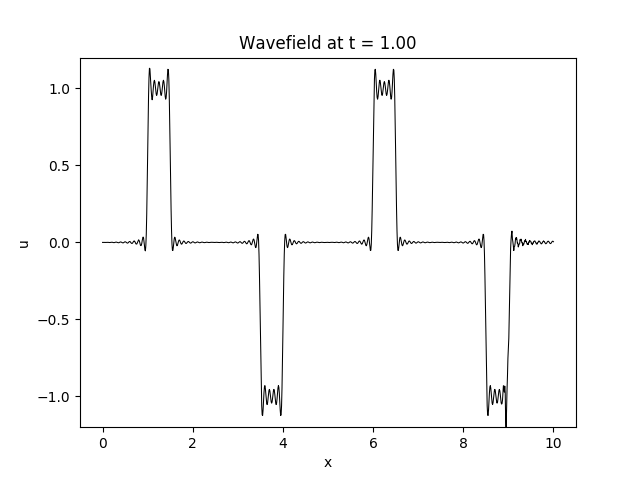

<IPython.core.display.Javascript object>


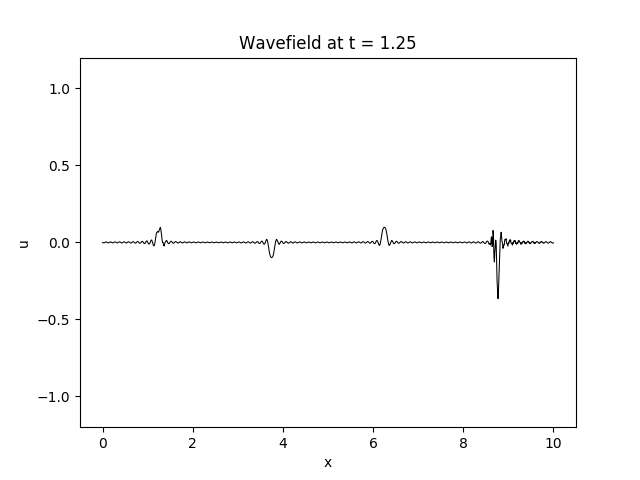

<IPython.core.display.Javascript object>


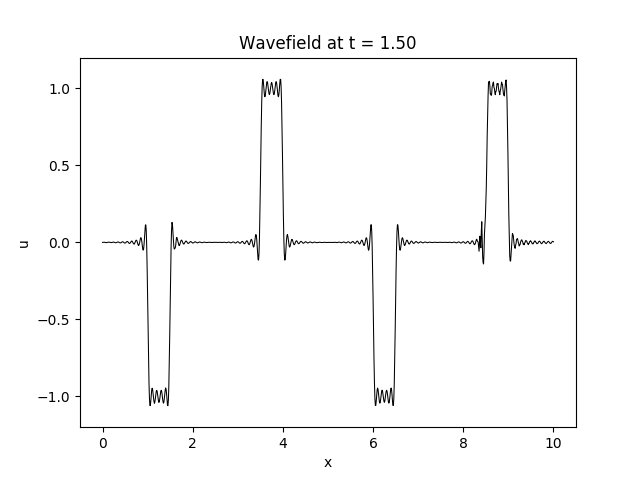

<IPython.core.display.Javascript object>


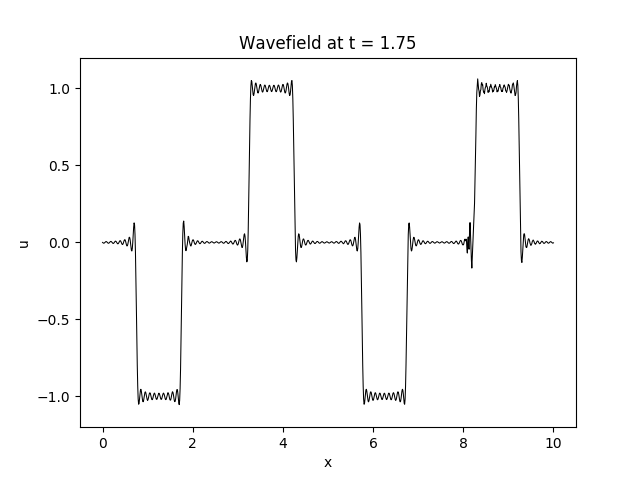

<IPython.core.display.Javascript object>


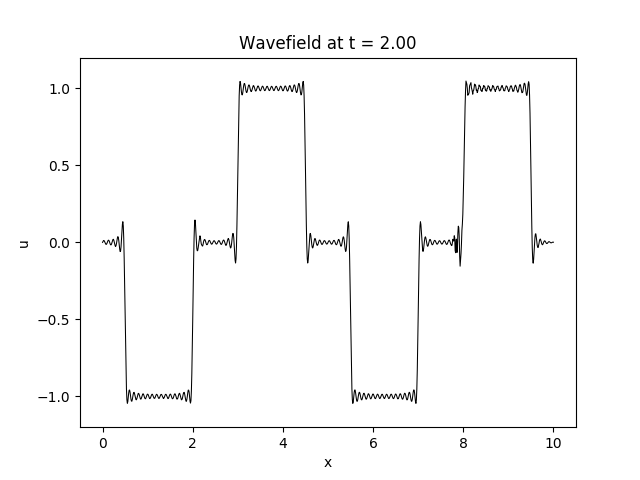

<IPython.core.display.Javascript object>


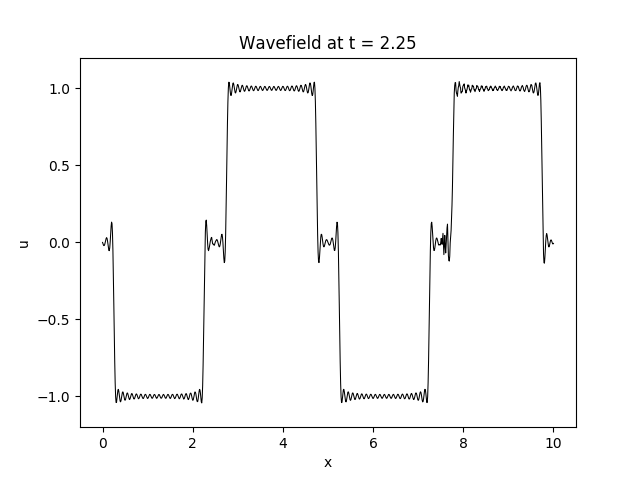

<IPython.core.display.Javascript object>


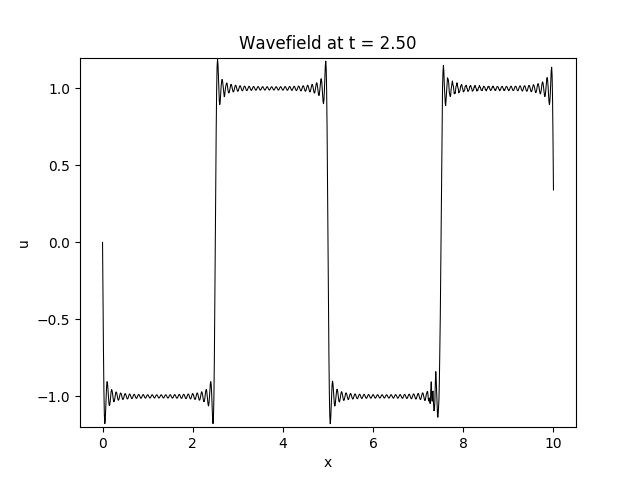

<IPython.core.display.Javascript object>


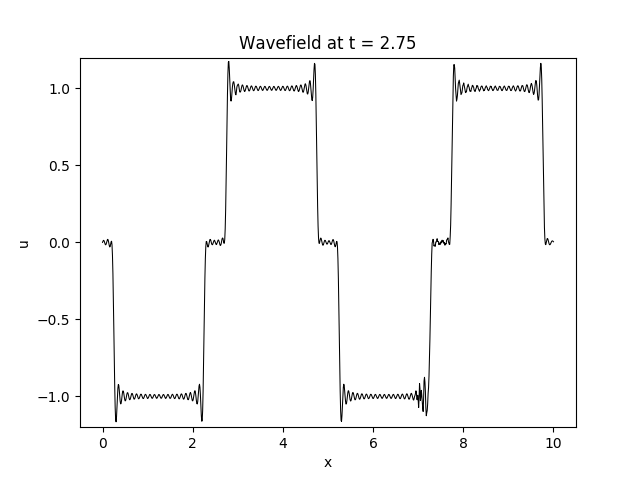

<IPython.core.display.Javascript object>


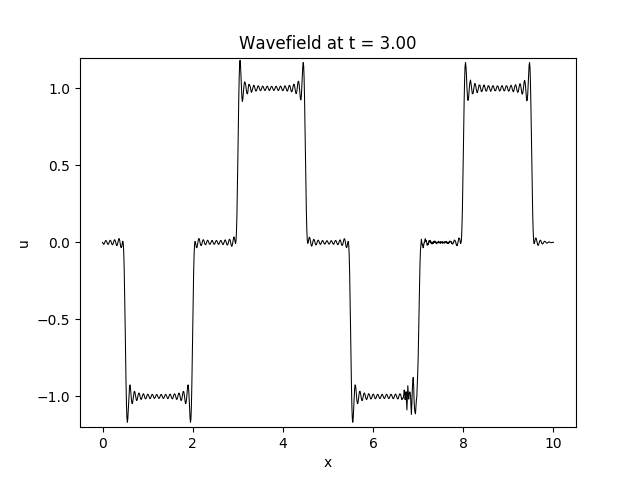

<IPython.core.display.Javascript object>


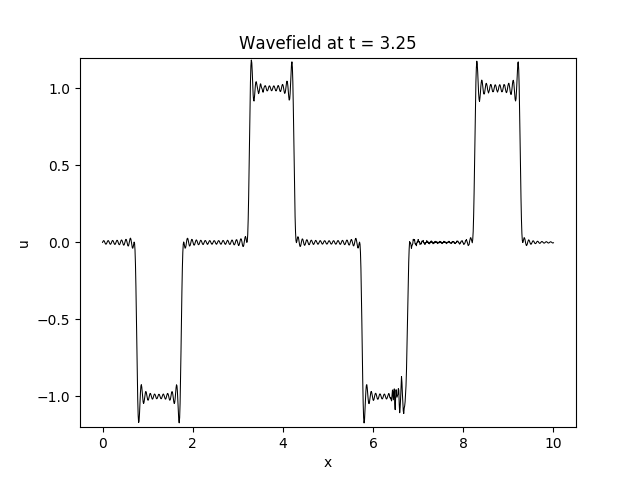

<IPython.core.display.Javascript object>


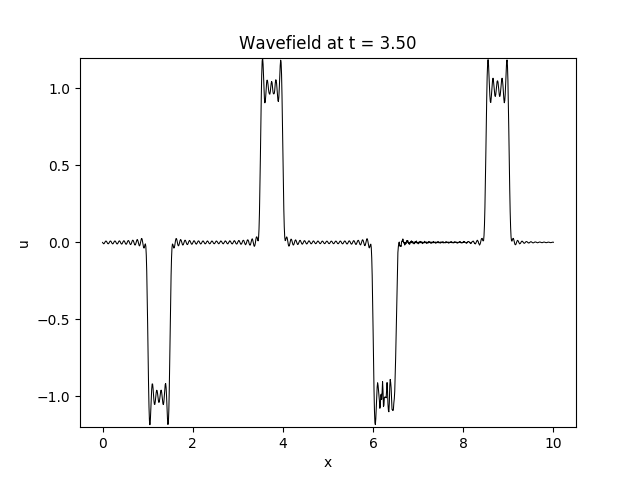

<IPython.core.display.Javascript object>


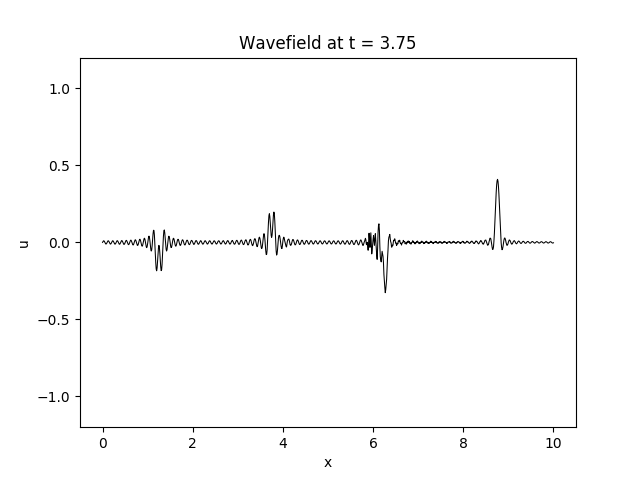

<IPython.core.display.Javascript object>


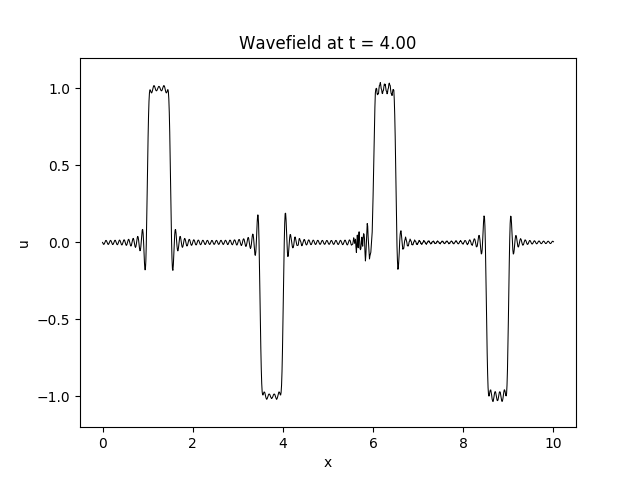

<IPython.core.display.Javascript object>


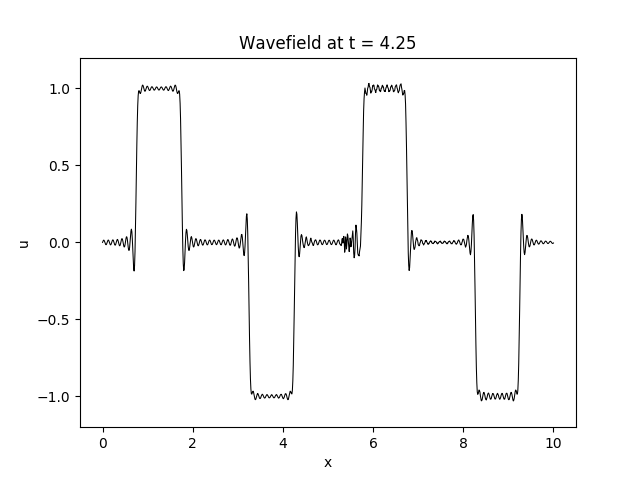

<IPython.core.display.Javascript object>


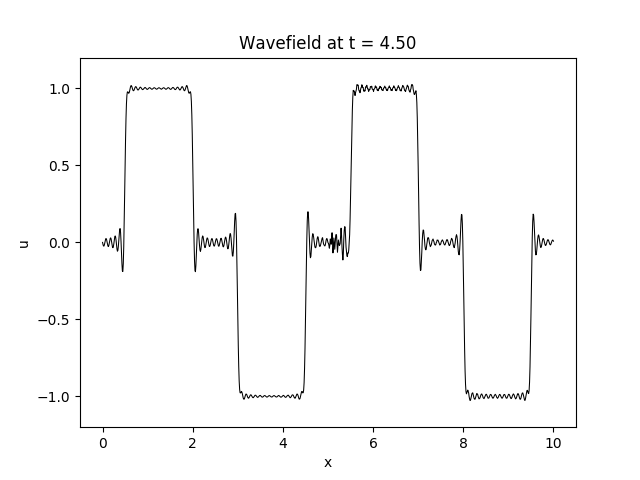

<IPython.core.display.Javascript object>


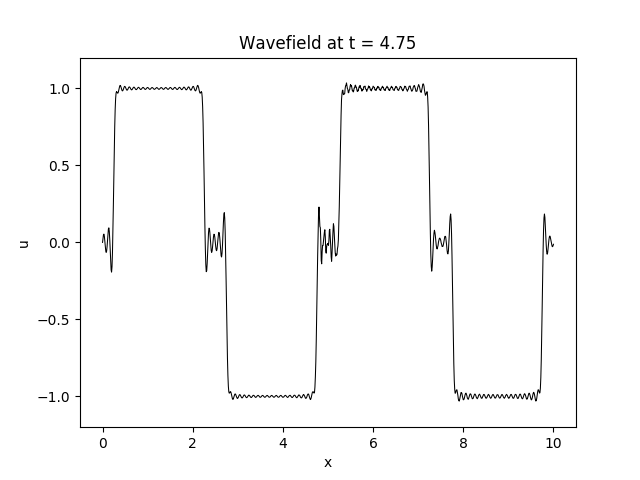

<IPython.core.display.Javascript object>


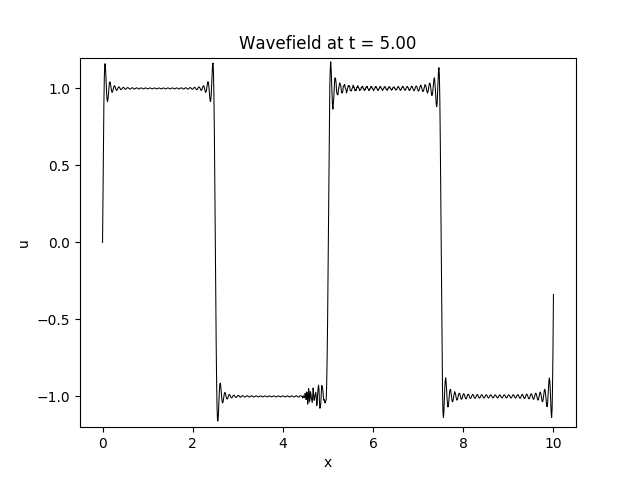

In [30]:
# Set up optimized FD parameters
so_opt = 4 # 6th order accurate in space
to_opt = 2 # 2nd order accurate in time
h_x = grid.spacing[0]

# Set up function and stencil
u_opt = TimeFunction(name="u_dev", grid=grid, space_order=so_opt, time_order=to_opt, save=ns+1)

# Optimized stencil coefficients
a_0 = -2.81299833
a_1 = 1.56808208
a_2 = -0.17723283
a_3 = 0.01564992

stencil_opt = Eq(u_opt.forward, solve((a_3*u_opt[time, x - 3]
                                      + a_2*u_opt[time, x - 2]
                                      + a_1*u_opt[time, x - 1]
                                      + a_0*u_opt[time, x]
                                      + a_1*u_opt[time, x + 1]
                                      + a_2*u_opt[time, x + 2]
                                      + a_3*u_opt[time, x + 3])/h_x**2
                                      - u_opt.dt2, u_opt.forward)[0])

bc = [Eq(u_opt[time+1,0], 0.0)] # Specify boundary conditions
bc += [Eq(u_opt[time+1,-1], 0.0)]

# Initialize wavefield
u_opt.data[:] = u_init(linspace(0, L, u_opt.data.shape[1]))
# Create operator
op_opt = Operator([stencil_opt] + bc)
# Apply operator
op_opt.apply(time_M=ns-1, dt=dt)

for i in range(21):
    fig = plt.figure()
    plt.plot(x_vals, u_opt.data[int(i*(u_opt.data.shape[0]-2)/40.)], 'k', linewidth=0.75)
    plt.title("Wavefield at t = %.2f" % (i*L/40.))
    plt.ylim(-1.2, 1.2)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.show()